In [61]:
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from collections import Counter

import string

import re

import seaborn as sns

from tqdm import tqdm

import matplotlib.pyplot as plt

import requests

from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [62]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [63]:
def clean(soup):
    soup1 = str(soup)
    soup1 = re.sub(r'[A-Za-z0-9]', '', soup1)
    soup1 = re.sub(r'\n|\ufeff|\xa0|[^\w\s]', '', soup1)
    soup1 = re.sub(r"\d+", "", soup1)
    soup1 = re.sub(r"\s+", " ", soup1)
    soup1 = re.sub(r"#|@|_|é|è|à", "", soup1)
    return soup1

In [64]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

In [65]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    for sent in x_train:
        words=sent.split(' ')
        for word in words:
            word = preprocess_string(word)
            if  word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    final_list_train,final_list_test = [],[]
    for sent in x_train:
        words=sent.split(' ')
        for word in words:
          if preprocess_string(word) in onehot_dict.keys():
            final_list_train.append([onehot_dict[preprocess_string(word)]])
    for sent in x_val:
      words=sent.split(' ')
      for word in words:
        if preprocess_string(word) in onehot_dict.keys():
            final_list_test.append([onehot_dict[preprocess_string(word)]])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_val),onehot_dict

In [66]:
def padding_(sentences, seq_len):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)

    features = pad_sequences(sequences, maxlen=seq_len, padding='post')

    return features

In [67]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [68]:
class LSTM(nn.Module):
    def __init__(self,vocab_size,no_layers=2,hidden_dim=256,embedding_dim=64,drop_prob=0.5,output_dim = 1):
        super(LSTM,self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        lstm_out, hidden = self.lstm(embeds, (h0, c0))
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [55]:
!pip install scrapy

In [69]:

import scrapy
from bs4 import BeautifulSoup

class ArabicQA_Spider(scrapy.Spider):
    name = 'arabic_qa'
    start_urls = [
        'https://akhbarak.net/blog/114808/%D8%A7%D8%B3%D8%A6%D9%84%D8%A9-%D8%AF%D9%8A%D9%86%D9%8A%D8%A9-%D8%A7%D8%B3%D9%84%D8%A7%D9%85%D9%8A%D8%A9-%D9%84%D9%84%D9%85%D8%B3%D8%A7%D8%A8%D9%82%D8%A7%D8%AA-%D8%B5%D8%B9%D8%A8%D8%A9-%D9%88%D8%B3/',
        # Ajoutez d'autres URL au besoin
    ]

    # Définissez une liste de mots-clés pertinents
    keywords = ['الله', 'رسول', 'إسلام', 'سورة', 'نبي', 'صحابة', 'قرآن', 'حديث', 'دين']

    def parse(self, response):
        soup = BeautifulSoup(response.text, 'html.parser')

        # Sélectionnez toutes les balises <li> qui sont enfants de <ul>
        question_items = soup.select('ul li')

        for item in question_items:
            # Récupérez le texte de la question (contenu de la balise <li>)
            question_text = item.find_all(text=True, recursive=False)
            question_text = ' '.join([text.strip() for text in question_text])

            # Récupérez le texte de la réponse (contenu de la balise <span> à l'intérieur de la balise <li>)
            answer_span = item.find('span')
            answer_text = answer_span.get_text(strip=True) if answer_span else None

            # Calculez le score basé sur la fréquence des mots-clés dans les balises <span>
            if answer_span:
                keyword_frequency = sum(keyword in answer_span.get_text(strip=True) for keyword in self.keywords)
                relevance_score = keyword_frequency  # Vous pouvez ajuster cela selon votre logique
            else:
                relevance_score = 0

            yield {
                'question': question_text,
                'score': relevance_score
            }




In [70]:
import pandas as pd
from io import BytesIO
from google.colab import files
upload = files.upload()
file_content = upload[list(upload.keys())[0]]
file_like_object = BytesIO(file_content)
df = pd.read_json(file_like_object)

Saving arabic_dataset.json to arabic_dataset (20).json


In [71]:
df


,Content,Score
0,,0
1,,0
2,,0
3,أول من سمي أحمد؟,2
4,أول من خلق الله تعالى هو؟,0
5,ما اسم خازن النار؟,0
6,ما هي أول عملة في تاريخ الدولة الإسلامية؟,1
7,ما هي السورة التي كانت السبب في إسلام عمر بن ا...,1
8,من هي أخت سيدنا مُحمد ـ صلَّى الله عليه وسلم؟,0
9,في أي سنة هجرية تم الفتح المُبين ورجع المسلمون...,0


In [72]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_arabic_text(text):

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('arabic'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    stemmer = ISRIStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [73]:
X,y = df['Content'].values,df['Score'].values
X = X.astype(str)
y = y.astype(str)
x_train,x_test,y_train,y_test = train_test_split(X,y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (35,)
shape of test data is (12,)


In [74]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
print(f'Length of vocabulary is {len(vocab)}')
X,y = df['Content'].values,df['Score'].values
x_train,x_test,y_train,y_test = train_test_split(X,y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

Length of vocabulary is 94
shape of train data is (35,)
shape of test data is (12,)


In [75]:
vocab

{'ما': 1,
 'هي': 2,
 'في': 3,
 'التي': 4,
 'القرآن': 5,
 'السورة': 6,
 'من': 7,
 'الكريم': 8,
 'سورة': 9,
 'أول': 10,
 'اسم': 11,
 'أعظم': 12,
 'الله': 13,
 'عدد': 14,
 'عليه': 15,
 'هو': 16,
 'ولكن': 17,
 'تبدأ': 18,
 'آية': 19,
 'محمد': 20,
 'تسمى': 21,
 'فيها': 22,
 'إسلام': 23,
 'عمر': 24,
 'بن': 25,
 'الخطاب': 26,
 'سور': 27,
 'السور': 28,
 'بـ': 29,
 'حروف': 30,
 'فقط': 31,
 'أخت': 32,
 'سيدنا': 33,
 'ـ': 34,
 'صلى': 35,
 'وسلم': 36,
 'فاتحة': 37,
 'الكتاب': 38,
 'خلق': 39,
 'تعالى': 40,
 'الصحابي': 41,
 'المكني': 42,
 'أبي': 43,
 'هريرة': 44,
 'بقلبالقرآن': 45,
 'أم': 46,
 'نبي': 47,
 'الصلاة': 48,
 'والسلام': 49,
 'خازن': 50,
 'النار': 51,
 'النبي': 52,
 'الذي': 53,
 'أطلق': 54,
 'الذبيح': 55,
 'كم': 56,
 'المرات': 57,
 'ورد': 58,
 'ذكر': 59,
 'رمضان': 60,
 'بها': 61,
 'عملة': 62,
 'تاريخ': 63,
 'الدولة': 64,
 'الإسلامية': 65,
 'استشهد': 66,
 'الإسلام': 67,
 'نزلت': 68,
 'لم': 69,
 'يذكر': 70,
 'لفظ': 71,
 'الجنة': 72,
 'بماذا': 73,
 'قتل': 74,
 'قابيل': 75,
 'أخيه': 76,
 'هابي

In [76]:
x_train_pad = padding_(x_train,50)
x_test_pad = padding_(x_test,50)

In [77]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

# for sample_x, sample_y in train_loader:
#     print('Sample input size: ', sample_x.size())
#     print('Sample input: \n', sample_x)
#     print('Sample input: \n', sample_y)

In [78]:
vocab_size = len(vocab) + 1
model = LSTM(vocab_size)
print(model)

LSTM(
  (embedding): Embedding(95, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [79]:
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

clip = 5
epochs = 5
valid_loss_min = np.Inf

In [92]:
from google.colab import drive

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        model.zero_grad()
        output,h = model(inputs,h)
                loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])
            inputs, labels = inputs.to(device), labels.to(device)
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())
            val_losses.append(val_loss.item())
            accuracy = acc(output,labels)
            val_acc += accuracy
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        drive.mount('/content/drive')
        model_state_path = '/content/drive/MyDrive/state_dict.pt'
        torch.save(model.state_dict(), model_state_path)
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(50*'==')

IndentationError: ignored

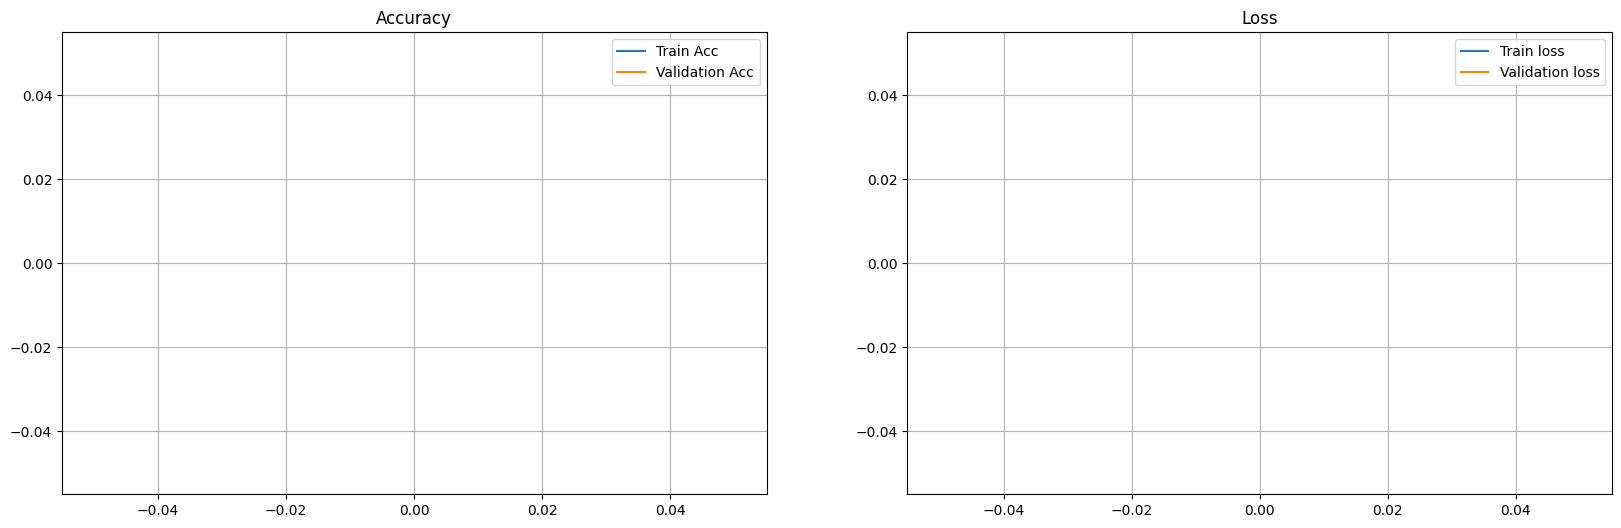

In [93]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [94]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])

        pad =  torch.from_numpy(padding_(str(word_seq),50))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        # pro = torch.sum(output).item()
        # pro = torch.mean(output).item()
        # return pro
        return(output.item())

In [95]:
index = 15
print(df['Content'][index])
print('='*70)
print(f'Actual score is  : {df["Score"][index]}')
print('='*70)
pro = predict_text(df['Content'][index])

print(f'Predicted score is {pro}')

في بعض السور القرآنية، قد نجد سجدة واحدة بها، ولكن هناك سورة تحتوي على سجدتين، فما هي؟ 
Actual score is  : 1


RuntimeError: ignored

In [96]:
index = 5
print(df['Content'][index])
print('='*70)
print(f'Actual sentiment is  : {df["Score"][index]}')
print('='*70)
pro = predict_text(df['Content'][index])

print(f'predicted score is {pro}')


ما اسم خازن النار؟ 
Actual sentiment is  : 0


RuntimeError: ignored